In [1]:
import sys
import glob
sys.path.append("../")
import CryoAsicAnalysis
import CryoAsicFile
import yaml
import pickle
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
plt.style.use("~/evanstyle.mplstyle")

In [2]:
datapath = "../../../data/MockTileRun1/Gamma_Data_Post_Surgery_7_15_24/"
datfiles = glob.glob(datapath+"*.dat")
pfiles = glob.glob(datapath+"*.p")

config_filepath = "../config/analysisconfig.yml"
print(datfiles)

[]


In [9]:
#check if any dat files haven't been converted yet, and do so
#OR you can auto reload all files
reload_all = True
for df in datfiles:
    filetag = df.split("/")[-1]
    filetag = filetag[:-4]
    found = False
    for pf in pfiles:
        pfiletag = pf.split("/")[-1]
        pfiletag = pfiletag[:-2]
        if(pfiletag == filetag):
            found = True
            break
    
    #if no pickle matching file was found, do the conversion
    if(found == False or reload_all):
        cf = CryoAsicFile.CryoAsicFile(df, config_filepath)
        cf.load_raw_data()
        cf.group_into_pandas()
        outfile_name = datapath+filetag+".p"
        cf.pickle_dump_waveform_df(outfile_name)



Read 2 events from CRYO ASIC file
Read 4 events from CRYO ASIC file
Read 6 events from CRYO ASIC file
Read 8 events from CRYO ASIC file
Read 10 events from CRYO ASIC file
Message
 <class 'IndexError'>
size [] previous size [ 5120016 16777218]
numberOfFrames read:  10
Finished reading raw binary, now descrambling the data
Done loading 10 CRYO ASIC events
Saving dataframe to file: ../../../data/LXe_Noise/Quiet_Data_All_Off_Take2_6g_1.2pt_20000us_1Hz_file5.p
Read 2 events from CRYO ASIC file
Read 4 events from CRYO ASIC file
Read 6 events from CRYO ASIC file
Read 8 events from CRYO ASIC file
Read 10 events from CRYO ASIC file
Message
 <class 'IndexError'>
size [] previous size [ 5120016 16777218]
numberOfFrames read:  10
Finished reading raw binary, now descrambling the data
Done loading 10 CRYO ASIC events
Saving dataframe to file: ../../../data/LXe_Noise/Quiet_Data_All_Off_Take2_6g_1.2pt_20000us_1Hz_file4.p
Read 2 events from CRYO ASIC file
Read 4 events from CRYO ASIC file
Read 6 event

In [13]:
#combine the dataframes from many files. 
infiles = glob.glob(datapath+"*.p")
full_df = None
for f in infiles:
    if("combined" in f):
        continue
    temp_df = pickle.load(open(f, "rb"))[0]
    if(full_df is None):
        full_df = temp_df
    else:
        full_df = pd.concat([full_df, temp_df], ignore_index=True)

pickle.dump([full_df], open(datapath+"combined_Quiet_Data_All_Off_Take_2_6g_12pt_20000us_1Hz.p", "wb"))

In [3]:
infile = datapath+"combined_Quiet_Data_All_Off_Take_2_6g_12pt_20000us_1Hz.p"
ca = CryoAsicAnalysis.CryoAsicAnalysis(infile, config_filepath)

"""
#OR, you can do it this way to have better editing of individual elements of the config
#open the yaml config into a dict
with open(config_filepath, 'r') as f:
    config = yaml.safe_load(f)

config["gain"] = 1 #for example

ca = CryoAsicAnalysis.CryoAsicAnalysis(infile, config=config)
"""

ca.baseline_subtract()



loading the waveform dataframe from  ../../../data/LXe_Noise/combined_Quiet_Data_All_Off_Take_2_6g_12pt_20000us_1Hz.p
Done loading


In [4]:
ca.calculate_avg_psds()

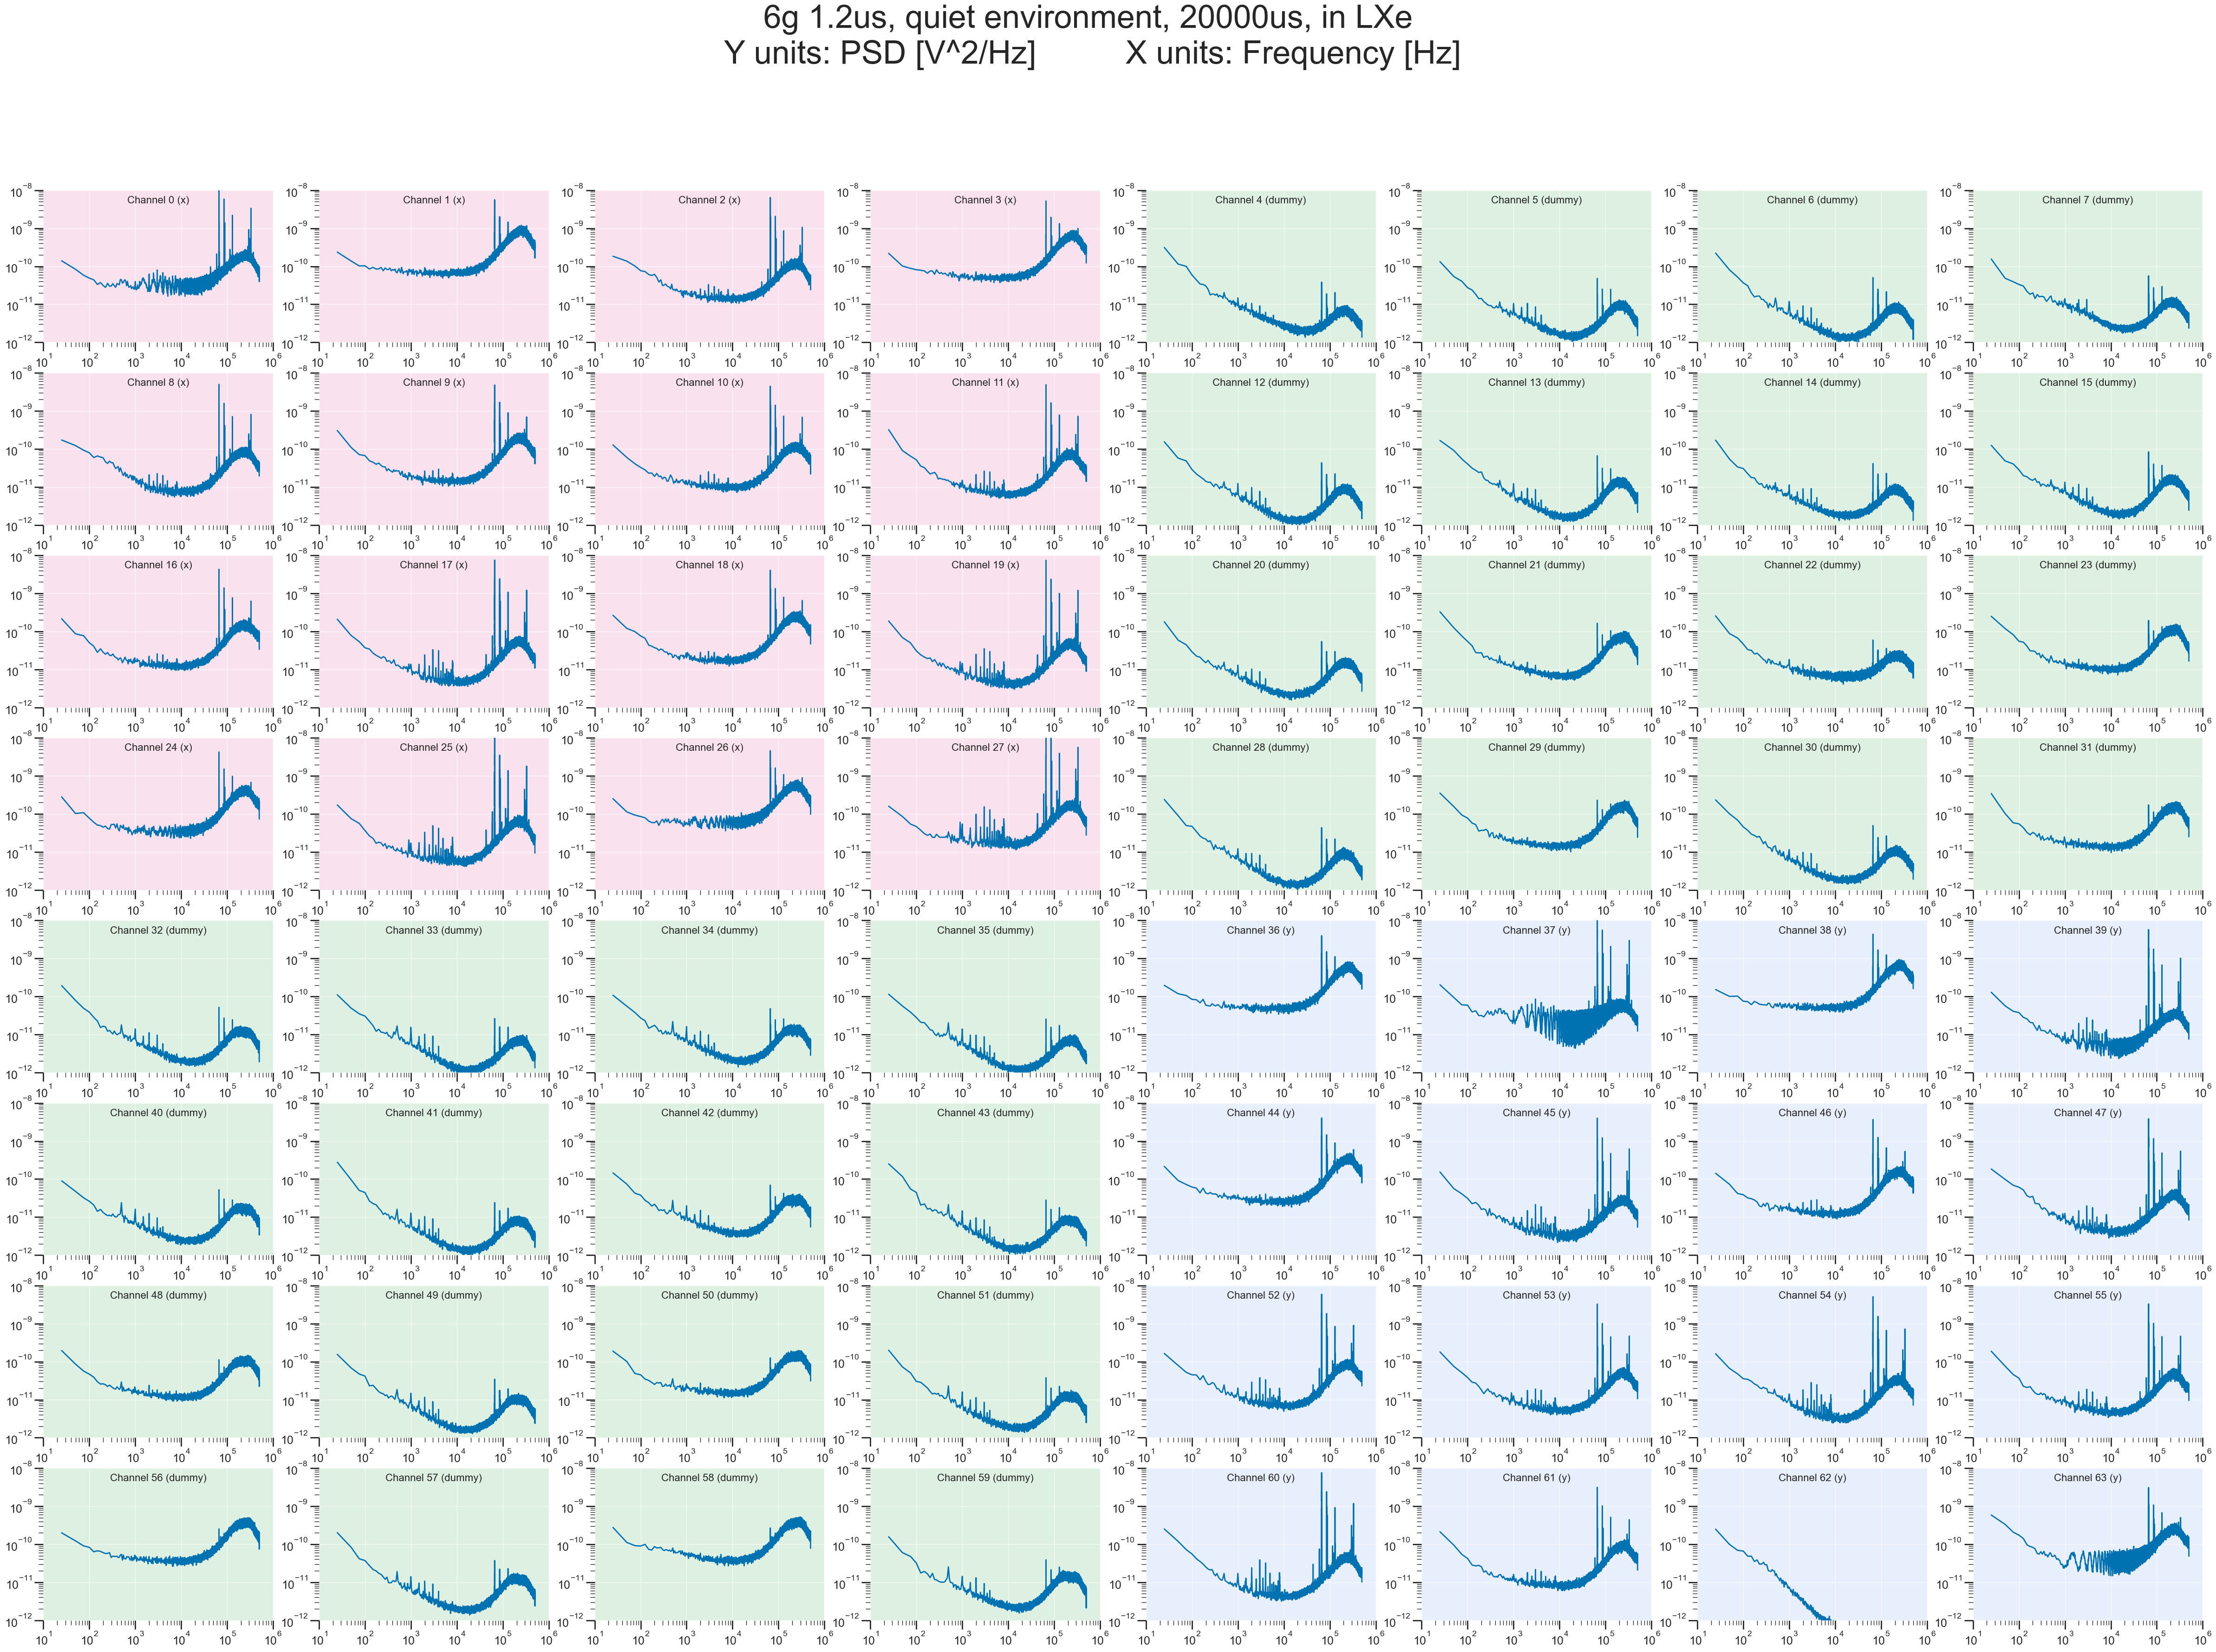

In [16]:
import math
#plot all psds on different plots
df = ca.noise_df    
fig, ax = plt.subplots(ncols=8, nrows=8, figsize=(60,40))
fig.suptitle("6g 1.2us, quiet environment, 20000us, in LXe\n Y units: PSD [V^2/Hz]          X units: Frequency [Hz]", fontsize=50)
for i, row in df.iterrows():
    ch = row["Channel"]
    typ = ca.get_channel_type(ch)
    r = int(ch % 8)
    c = int(math.floor(ch/8))
    ax[c][r].plot(row["Freqs"], row["PSD"])
    ax[c][r].set_title(f"Channel {ch} ({typ})", y=1, pad=-20)
    ax[c][r].set_xscale("log")
    ax[c][r].set_yscale("log")
    #ax[c][r].set_xlabel("Frequency (Hz)")
    #ax[c][r].set_ylabel("PSD (V^2/Hz)")
    ax[c][r].set_ylim([1e-12, 1e-8])
    ax[c][r].set_xlim([1e1, 1e6])
    if(typ == "x"):
        ax[c][r].set_facecolor("#fae1ee")
    elif(typ == "y"):
        ax[c][r].set_facecolor("#e8effc")
    else:
        ax[c][r].set_facecolor("#ddf0e2")

plt.savefig("all_psds.png")

    

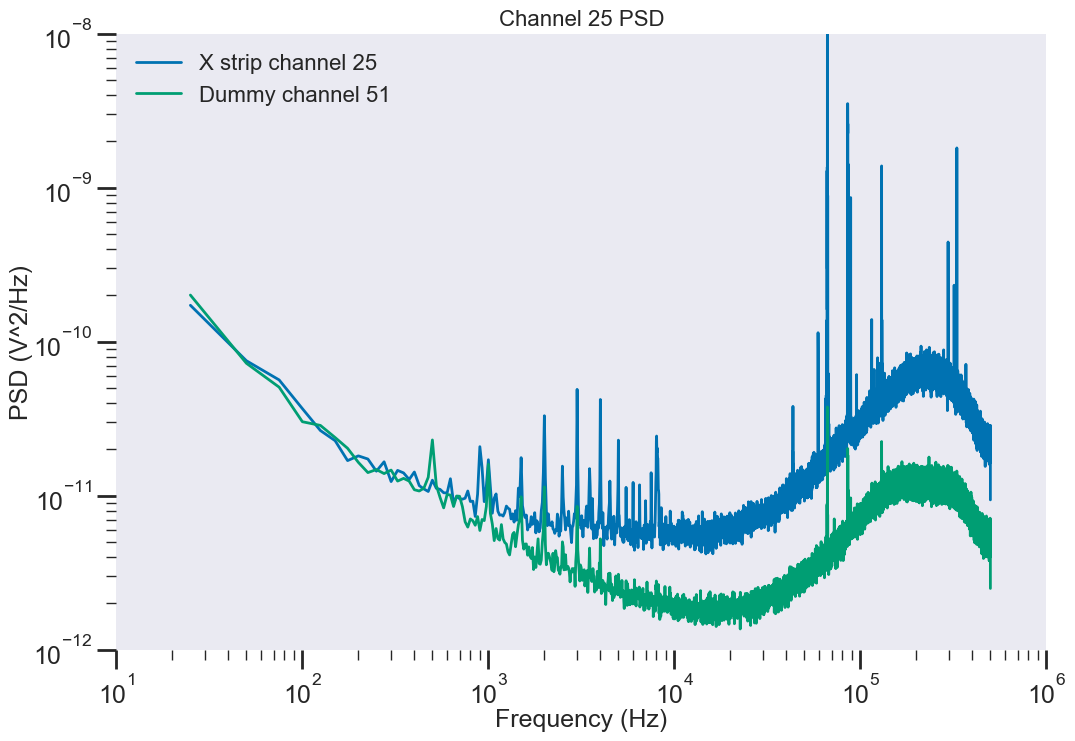

In [46]:
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter

dummy_channel = 51
strip_channel = 25


#peak finding settings

min_dist = 20 #samples in the log binned histogram
min_width = 1 #samples minimum width of peak
prom = 0.25 #minimum prominence of peak
all_freqs = []



#plot a single channel's PSD
fig, ax = plt.subplots()
df = ca.noise_df
for i, row in df.iterrows():
    if(row["Channel"] == dummy_channel):
        ax.plot(row["Freqs"], row["PSD"], label=f"Dummy channel {dummy_channel}")
        
        #to find peaks, actually take the logarithm of the data 
        y = np.log10(row["PSD"])
        x = row["Freqs"]
        peaks, _ = find_peaks(y, distance=min_dist, width=min_width, prominence=prom)
        peak_values = y[peaks]
        peak_freqs = x[peaks]
        all_freqs += peak_freqs.tolist()
        
        
    elif(row["Channel"] == strip_channel):
        ax.plot(row["Freqs"], row["PSD"], label=f"X strip channel {strip_channel}")

        #to find peaks, actually take the logarithm of the data 
        y = np.log10(row["PSD"])
        x = row["Freqs"]
        peaks, _ = find_peaks(y, distance=min_dist, width=min_width, prominence=prom)
        peak_values = y[peaks]
        peak_freqs = x[peaks]
        all_freqs += peak_freqs.tolist()


ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("PSD (V^2/Hz)")
ax.set_title(f"Channel {strip_channel} PSD")
ax.legend()
ax.grid(False)
ax.set_ylim([1e-12, 1e-8])
ax.set_xlim([1e1, 1e6])

#for i, p in enumerate(all_freqs):
#    ax.annotate("{:.3f} kHz".format(p/1e3), (p, 5e-9), ha='center', va='top', fontsize=15, color='k', rotation=90)


plt.show()

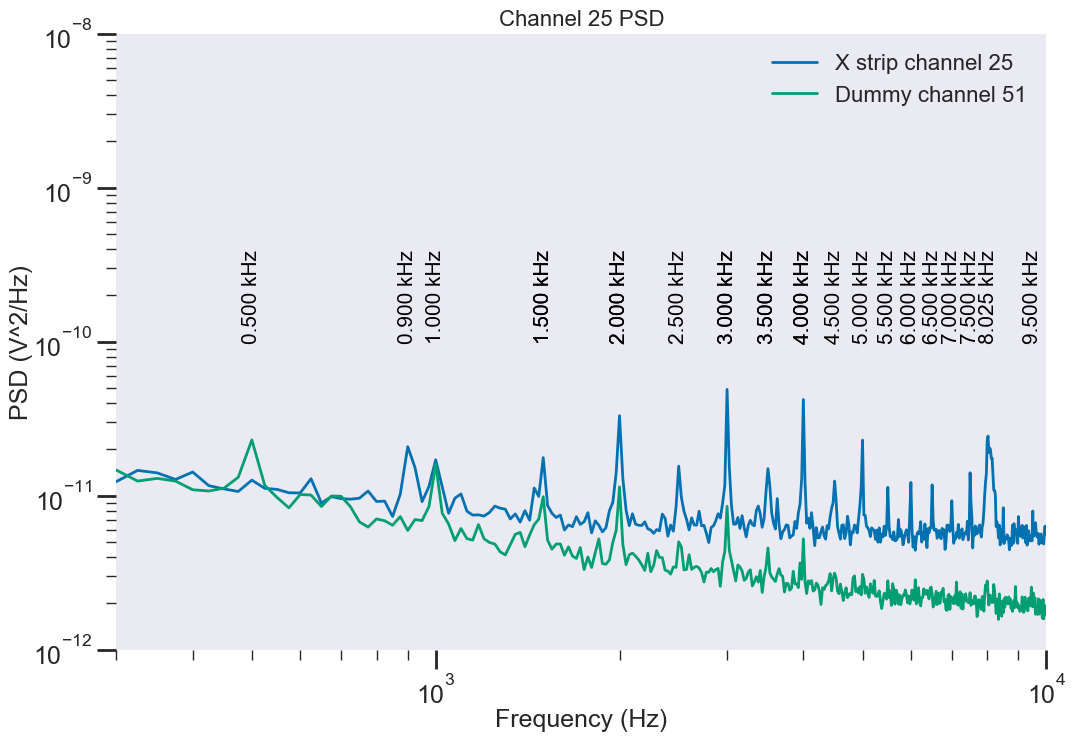

In [31]:
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter

dummy_channel = 51
strip_channel = 25


#peak finding settings

min_dist = 20 #samples in the log binned histogram
min_width = 1 #samples minimum width of peak
prom = 0.25 #minimum prominence of peak
all_freqs = []



#plot a single channel's PSD
fig, ax = plt.subplots()
df = ca.noise_df
for i, row in df.iterrows():
    if(row["Channel"] == dummy_channel):
        ax.plot(row["Freqs"], row["PSD"], label=f"Dummy channel {dummy_channel}")
        
        #to find peaks, actually take the logarithm of the data 
        y = np.log10(row["PSD"])
        x = row["Freqs"]
        peaks, _ = find_peaks(y, distance=min_dist, width=min_width, prominence=prom)
        peak_values = y[peaks]
        peak_freqs = x[peaks]
        all_freqs += peak_freqs.tolist()
        
        
    elif(row["Channel"] == strip_channel):
        ax.plot(row["Freqs"], row["PSD"], label=f"X strip channel {strip_channel}")

        #to find peaks, actually take the logarithm of the data 
        y = np.log10(row["PSD"])
        x = row["Freqs"]
        peaks, _ = find_peaks(y, distance=min_dist, width=min_width, prominence=prom)
        peak_values = y[peaks]
        peak_freqs = x[peaks]
        all_freqs += peak_freqs.tolist()


ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("PSD (V^2/Hz)")
ax.set_title(f"Channel {strip_channel} PSD")
ax.legend()
ax.grid(False)
ax.set_ylim([1e-12, 1e-8])
ax.set_xlim([300, 10e3])

for i, p in enumerate(all_freqs):
    ax.annotate("{:.3f} kHz".format(p/1e3), (p, 0.4e-9), ha='center', va='top', fontsize=15, color='k', rotation=90)


plt.show()

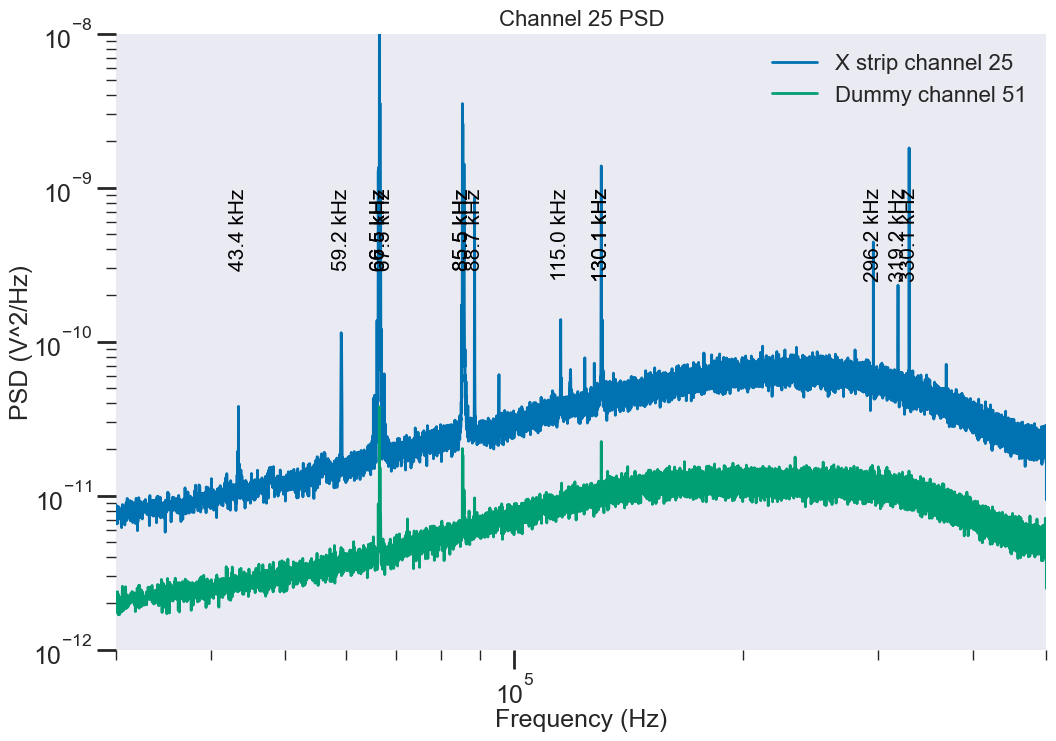

In [45]:
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter

dummy_channel = 51
strip_channel = 25


#peak finding settings

min_dist = 20 #samples in the log binned histogram
min_width = 1 #samples minimum width of peak
prom = 0.5 #minimum prominence of peak
all_freqs = []



#plot a single channel's PSD
fig, ax = plt.subplots()
df = ca.noise_df
for i, row in df.iterrows():
    if(row["Channel"] == dummy_channel):
        ax.plot(row["Freqs"], row["PSD"], label=f"Dummy channel {dummy_channel}")
        
        #to find peaks, actually take the logarithm of the data 
        y = np.log10(row["PSD"])
        x = row["Freqs"]
        peaks, _ = find_peaks(y, distance=min_dist, width=min_width, prominence=prom)
        peak_values = y[peaks]
        peak_freqs = x[peaks]
        all_freqs += peak_freqs.tolist()
        
        
    elif(row["Channel"] == strip_channel):
        ax.plot(row["Freqs"], row["PSD"], label=f"X strip channel {strip_channel}")

        #to find peaks, actually take the logarithm of the data 
        y = np.log10(row["PSD"])
        x = row["Freqs"]
        peaks, _ = find_peaks(y, distance=min_dist, width=min_width, prominence=prom)
        peak_values = y[peaks]
        peak_freqs = x[peaks]
        all_freqs += peak_freqs.tolist()


ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("PSD (V^2/Hz)")
ax.set_title(f"Channel {strip_channel} PSD")
ax.legend()
ax.grid(False)
ax.set_ylim([1e-12, 1e-8])
ax.set_xlim([3e4, 5e5])

for i, p in enumerate(all_freqs):
    ax.annotate("{:.1f} kHz".format(p/1e3), (p, 1e-9), ha='center', va='top', fontsize=15, color='k', rotation=90)


plt.show()

# Testing the PSD function that uses pulse finding 

In [3]:
datapath = "../../../data/MockTileRun1/Gamma_Data_Post_Surgery_7_15_24/"
datfiles = glob.glob(datapath+"*.dat")
pfiles = glob.glob(datapath+"*.p")

config_filepath = "../config/analysisconfig.yml"
print(datfiles)

[]


In [59]:
infile = pfiles[0]
ca = CryoAsicAnalysis.CryoAsicAnalysis(infile, config_filepath)
ca.baseline_subtract()

loading the waveform dataframe from  ../../../data/MockTileRun1/Gamma_Data_Post_Surgery_7_15_24/Gamma_Data_Post_Surgery_5kV_7_15_24_initcryo_4_6g_12pt_1000us_file2406.p
Done loading


In [74]:
ca.calculate_avg_psds_ignore_pulses()

/Users/ejangelico/anaconda3/envs/llnl/lib/python3.11/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/fast_impl.py:102: RuntimeWarning: invalid value encountered in divide
  tan_2omega_tau = (S2 - 2 * S * C) / (C2 - (C * C - S * S))
/Users/ejangelico/anaconda3/envs/llnl/lib/python3.11/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/fast_impl.py:131: RuntimeWarning: divide by zero encountered in divide
  power = YC * YC / CC + YS * YS / SS
/Users/ejangelico/anaconda3/envs/llnl/lib/python3.11/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/fast_impl.py:102: RuntimeWarning: divide by zero encountered in divide
  tan_2omega_tau = (S2 - 2 * S * C) / (C2 - (C * C - S * S))
/Users/ejangelico/anaconda3/envs/llnl/lib/python3.11/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/fast_impl.py:113: RuntimeWarning: invalid value encountered in divide
  S2w = tan_2omega_tau / np.sqrt(1 + tan_2omega_ta

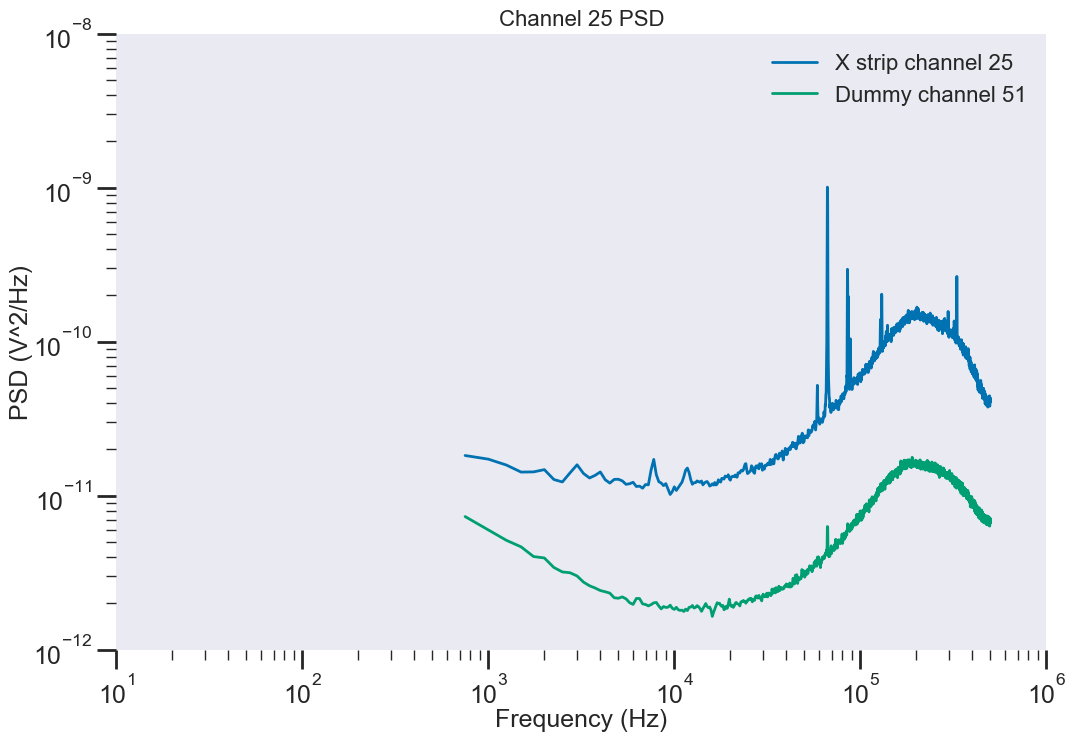

In [75]:
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter

dummy_channel = 51
strip_channel = 25


#peak finding settings

min_dist = 20 #samples in the log binned histogram
min_width = 1 #samples minimum width of peak
prom = 0.25 #minimum prominence of peak
all_freqs = []



#plot a single channel's PSD
fig, ax = plt.subplots()
df = ca.noise_df
for i, row in df.iterrows():
    if(row["Channel"] == dummy_channel):
        ax.plot(row["Freqs"], row["PSD"], label=f"Dummy channel {dummy_channel}")
        
        #to find peaks, actually take the logarithm of the data 
        y = np.log10(row["PSD"])
        x = row["Freqs"]
        peaks, _ = find_peaks(y, distance=min_dist, width=min_width, prominence=prom)
        peak_values = y[peaks]
        peak_freqs = x[peaks]
        all_freqs += peak_freqs.tolist()
        
        
    elif(row["Channel"] == strip_channel):
        ax.plot(row["Freqs"], row["PSD"], label=f"X strip channel {strip_channel}")

        #to find peaks, actually take the logarithm of the data 
        y = np.log10(row["PSD"])
        x = row["Freqs"]
        peaks, _ = find_peaks(y, distance=min_dist, width=min_width, prominence=prom)
        peak_values = y[peaks]
        peak_freqs = x[peaks]
        all_freqs += peak_freqs.tolist()


ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("PSD (V^2/Hz)")
ax.set_title(f"Channel {strip_channel} PSD")
ax.legend()
ax.grid(False)
ax.set_ylim([1e-12, 1e-8])
ax.set_xlim([1e1, 1e6])

#for i, p in enumerate(all_freqs):
#    ax.annotate("{:.3f} kHz".format(p/1e3), (p, 5e-9), ha='center', va='top', fontsize=15, color='k', rotation=90)


plt.show()

In [76]:
ca.calculate_avg_psds()